<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/ColorizationTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [2]:
!cat /etc/issue

Ubuntu 18.04.1 LTS \n \l



In [3]:
!nvidia-smi

Sun Feb 10 13:15:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
#http://www.programmersought.com/article/1829252929/
!apt install caffe-cuda > /dev/null
!echo done



Extracting templates from packages: 100%
done


In [5]:
import caffe
caffe.__version__

'1.0.0'

In [6]:
!git clone https://github.com/richzhang/colorization.git

Cloning into 'colorization'...
remote: Enumerating objects: 4812, done.
remote: Total 4812 (delta 0), reused 0 (delta 0), pack-reused 4812
Receiving objects: 100% (4812/4812), 176.13 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (385/385), done.


In [7]:
%cd colorization/

/content/colorization


In [8]:
%cd demo

/content/colorization/demo


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import caffe
import os
import skimage.color as color
import scipy.ndimage.interpolation as sni

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
!wget -O ../models/colorization_release_v1.caffemodel http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel

--2019-02-10 13:16:55--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel [following]
--2019-02-10 13:16:56--  https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128948189 (123M)
Saving to: ‘../models/colorization_release_v1.caffemodel’

../models/colorizat 100%[================

In [0]:
gpu_id = 0
caffe.set_mode_gpu()
caffe.set_device(gpu_id)
net = caffe.Net('../models/colorization_deploy_v1.prototxt', '../models/colorization_release_v1.caffemodel', caffe.TEST)

(H_in,W_in) = net.blobs['data_l'].data.shape[2:] # get input shape
(H_out,W_out) = net.blobs['class8_ab'].data.shape[2:] # get output shape
net.blobs['Trecip'].data[...] = 6/np.log(10) # 1/T, set annealing temperature
    # (We found that we had introduced a factor of log(10). We will update the arXiv shortly.)

※下記のW_orig/10はW_orig//10にすること

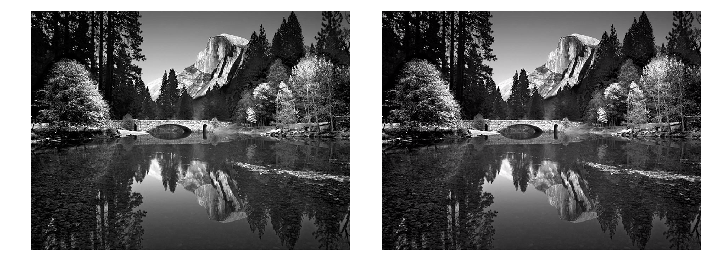

In [16]:
# load the original image
img_rgb = caffe.io.load_image('./imgs/ansel_adams3.jpg')
img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.shape[:2] # original image size

# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

# resize image to network input size
img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
img_lab_rs = color.rgb2lab(img_rs)
img_l_rs = img_lab_rs[:,:,0]

# show original image, along with grayscale input
img_pad = np.ones((H_orig,W_orig//10,3))
plt.imshow(np.hstack((img_rgb, img_pad, img_rgb_bw)))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1870 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


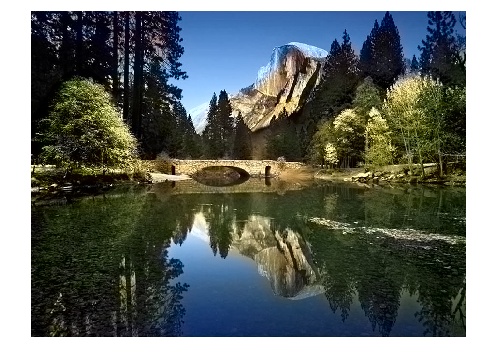

In [17]:
net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plt.imshow(img_rgb_out);
plt.axis('off');

env: WEBIMG=https://i.gzn.jp/img/2011/04/24/midnight_shot_nv_1/e5b5_midnight_shot_nv-1_night_vision_camera_inuse.jpg
env: WEBIMG=https://www.avaldata.co.jp/products/z2_imaging/near-infrared_camera/image/p_apple.jpg
env: WEBIMG=https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBCdlGCnfkNpWAWO-MtvnaS-KUeAngj3nGqhSgqcX-CPta_9yo
env: WEBIMG=https://i.ytimg.com/vi/A4_0R2pmMpw/maxresdefault.jpg
--2019-02-10 13:22:43--  https://i.ytimg.com/vi/A4_0R2pmMpw/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.140.119, 108.177.15.119, 173.194.76.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|74.125.140.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46495 (45K) [image/jpeg]
Saving to: ‘temp.jpg’

temp.jpg            100%[===================>]  45.41K  --.-KB/s    in 0s      

2019-02-10 13:22:43 (96.9 MB/s) - ‘temp.jpg’ saved [46495/46495]



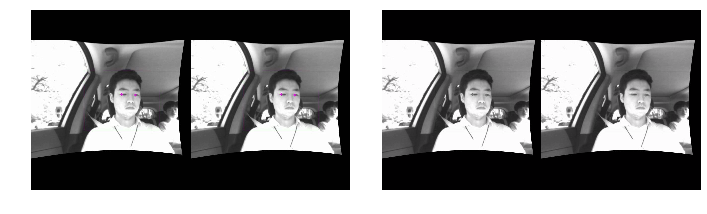

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 704 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


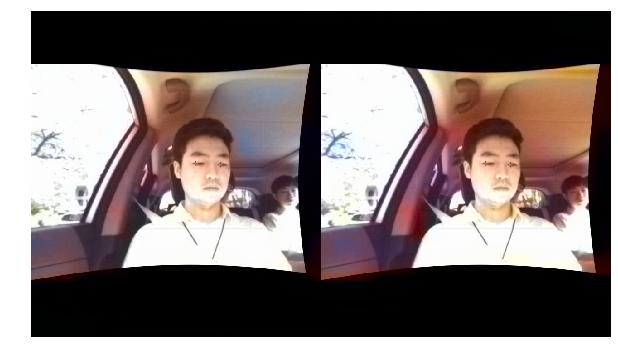

In [19]:
%env WEBIMG=https://i.gzn.jp/img/2011/04/24/midnight_shot_nv_1/e5b5_midnight_shot_nv-1_night_vision_camera_inuse.jpg
%env WEBIMG=https://www.avaldata.co.jp/products/z2_imaging/near-infrared_camera/image/p_apple.jpg  
%env WEBIMG=https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBCdlGCnfkNpWAWO-MtvnaS-KUeAngj3nGqhSgqcX-CPta_9yo
%env WEBIMG=https://i.ytimg.com/vi/A4_0R2pmMpw/maxresdefault.jpg
#%env WEBIMG=https://cdn.instructables.com/FE3/W619/FHPVYAN1/FE3W619FHPVYAN1.LARGE.jpg
!wget $WEBIMG -O temp.jpg > /dev/null

# load the original image
img_rgb = caffe.io.load_image('./temp.jpg')
img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.shape[:2] # original image size

# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

# resize image to network input size
img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
img_lab_rs = color.rgb2lab(img_rs)
img_l_rs = img_lab_rs[:,:,0]

# show original image, along with grayscale input
img_pad = np.ones((H_orig,W_orig//10,3))
plt.imshow(np.hstack((img_rgb, img_pad, img_rgb_bw)))
plt.axis('off');
plt.show()

# Do Colorization
net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plt.imshow(img_rgb_out);
plt.axis('off');